# Trennung Signal-Hintergrund - Kontur
Im vorherigen Jupyter-Notebook (JN) `sb01-yml2csv.ipynb` sind die Rohdaten für die Wellen aufbereitet worden 
und als CSV-Datei ausgegeben worden.
- In den Hintergrunddaten sind diejenigen Wellen eliminiert worden, bei denen der maximale (negative) Impuls
den Schwellwert von $8000$ überschritten haben. Damit ist die maximale Impulshöhe keine geeignete
Eigenschaft für das Training, da diese Eigenschaft für die Ermittlung der Trainingsdaten einen wesentlichen Einfluss hat.
- Darüber hinaus wurden diejenigen Wellen (bei den Signalen und beim Hintergrund) eliminiert,
deren maximaler Impuls zu weit am Rande des Aufnahmezeitraums von 100 Pixel lag.

Im JN `sb02-separate.ipynb` wird aus den 100-Pixel-Rohdaten ein Bereich von 25-Pixel um den maximalen (negativen) Impuls herausgegriffen.
Dieser Bereich wird dahingehend normiert, dass der maximale (negative) Impuls beim Wert $32000$ liegt. 
Damit haben alle Wellen, egal ob Signal oder Hintergrund denselben maximalen Impuls.
Neben den 25 Werten für den Wellenverlauf ist die Nummer der Welle in den Originaldaten 
und das Label, das Kennzeichen, ob Signal oder Hintergrund enthalten.
Das ist die Trainingsmenge.

In weiteren CSV-Dateien sind die Originaldaten der Wellen beziehungsweise einige Informationen zu den Wellen.
Damit können dann Plots von Lerndaten und Originaldaten dargestellt werden.

## 1. Vorbereitungen

In [1]:
# --- imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
import time, timeit
from tools_confmatrix import show_confusion_matrix_extended, get_confusion_matrix_values, show_confusion_matrix_line
from tools_showwaves import show_waves
from general_parameters import LABEL_SIGNAL, LABEL_BACKGROUND, RANDOM_STATE

In [2]:
# --- parameters
filename_inp = "data\sbData.csv"

In [3]:
# --- load data from CSV-files
data_complete = np.loadtxt (filename_inp, delimiter=";", skiprows=1)
print ("data  ", data_complete.shape)
print ()

n_instances = len (data_complete)
print (f"number of instances: {n_instances:d}")

data   (23754, 137)

number of instances: 23754


### Darstellungen einiger Wellen
Im nachfolgenden werden einige Wellen beispielhaft dargestellt. 
Einmal ohne die Originalwelle, also die Daten, welche in die Auswertung eingehen.
Einmal mit der Originalwelle, um zu sehen, wie der Auszug im Vergleich zu den Originaldaten aussehen.

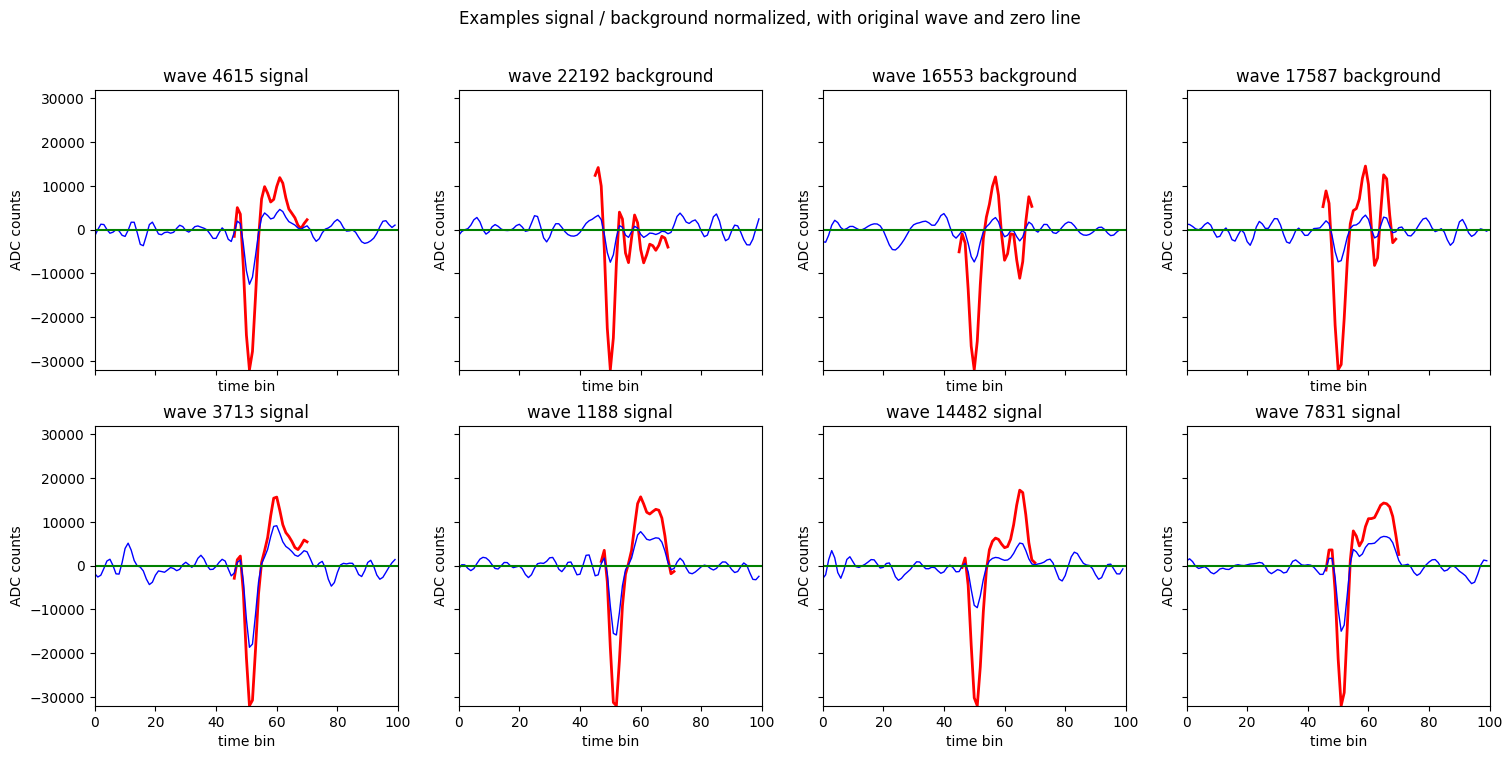

In [4]:
title = "Examples signal / background normalized, with original wave and zero line"
figsize = (18.,8.)
#figsize = (5.,4.)
items = []
show_waves (data_complete, title=title, n_cols=4, n_rows=2, \
            source="random", items=items , figsize=figsize, withLabel=True, withIndex=True, \
            withOrg=True, withContour=True, withAxisLabelling=True, withZeroLine=True)

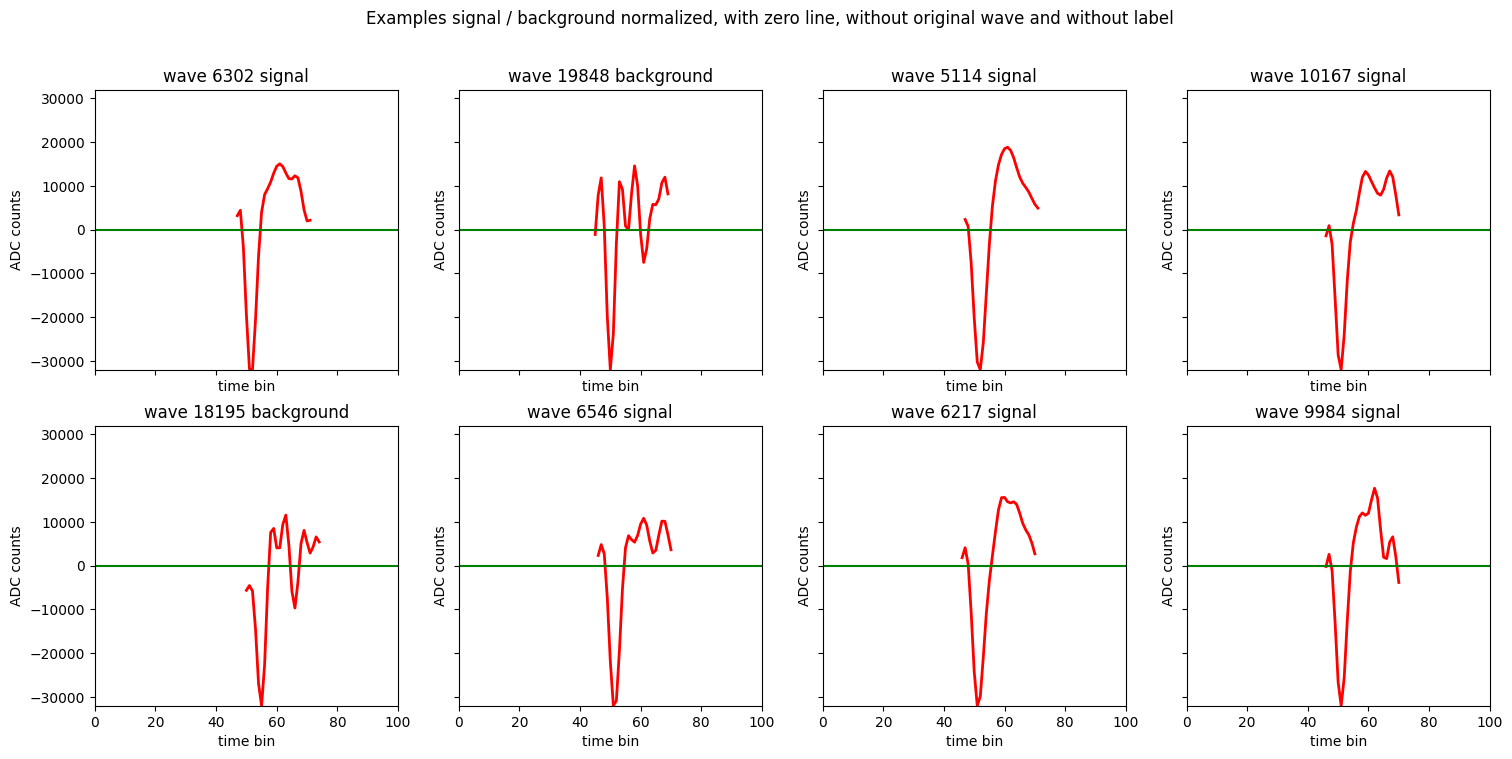

In [5]:
title = "Examples signal / background normalized, with zero line, without original wave and without label"
figsize = (18.,8.)
show_waves (data_complete, title, n_cols=4, n_rows=2, source="random", figsize=figsize, \
            withLabel=True, withIndex=True, withOrg=False, withContour=True, withAxisLabelling=True, withZeroLine=True)

## 2 Die Kontur-Daten als Lerndaten verwenden
Die Kontur-Daten werden nun für verschiedenen ML-Algorithmen verwendet. Dazu werden die Trainings- und Testmenge erzeugt.

Die einzelnen Instanzen enthalten neben den 25 Datenpunkten der Welle und dem Label 
auch noch einen Index, der auf die originale Welle verweist. Dies wird verwendet,
um später die Wellen zusammen mit den Originaldaten zu plotten. [Wird der Index verwendet?]

In [6]:
# --- prepare the learning set plus additional information
#     --- parameter setting
row_indices = [100] + list (range (104, 129))
data_features = data_complete [:,row_indices]
data_label = data_complete [:,-1]

print ("features : ", data_features.shape)
print ("label    : ", data_label.shape)
print ("number of instances : ", len (data_features))

features :  (23754, 26)
label    :  (23754,)
number of instances :  23754


In [7]:
# --- split in training set / test set
test_size = 0.25
X_train_plus, X_test_plus, y_train, y_test \
    = train_test_split (data_features, data_label, test_size=test_size, random_state=RANDOM_STATE)
X_train = X_train_plus [:,1:]
X_test = X_test_plus [:,1:]
print (f"Elements in the training set   : {X_train.shape [0]:5d}")
unique, counts = np.unique (y_train, return_counts = True)
print (f"  thereof signals              : {counts [1]:5d}")
print (f"Elements in the test set       : {X_test.shape [0]:5d}")
unique, counts = np.unique (y_test, return_counts = True)
print (f"  thereof signals              : {counts [1]:5d}")

print ("data_features: ", data_features.shape)
print ("X_train_plus : ", X_train_plus.shape)
print ("X_train      : ", X_train.shape)

Elements in the training set   : 17815
  thereof signals              : 10987
Elements in the test set       :  5939
  thereof signals              :  3679
data_features:  (23754, 26)
X_train_plus :  (17815, 26)
X_train      :  (17815, 25)


Die Daten werden dahingehend skaliert, dass der maximale (negative) Impuls den Wert -1 hat.

In [8]:
#scaler = StandardScaler() 
#scaler.fit (X_train)
#X_train_scaled = scaler.transform (X_train) 
#X_test_scaled = scaler.transform (X_test)

X_train_scaled = X_train / 32000.0
X_test_scaled = X_test / 32000.0

## 3 ML-Algorithmus: Logistics Regression
Als erstes wird eine Logistische Regression für die binäre Klassifikation angewendet.

In [9]:
# --- train logistics regression
log_reg = LogisticRegression (max_iter=1000, solver='lbfgs') 
log_reg.fit (X_train_scaled, y_train) 

LogisticRegression(max_iter=1000)

Nun wird die ROC-Kurve ermittelt und geplottet.

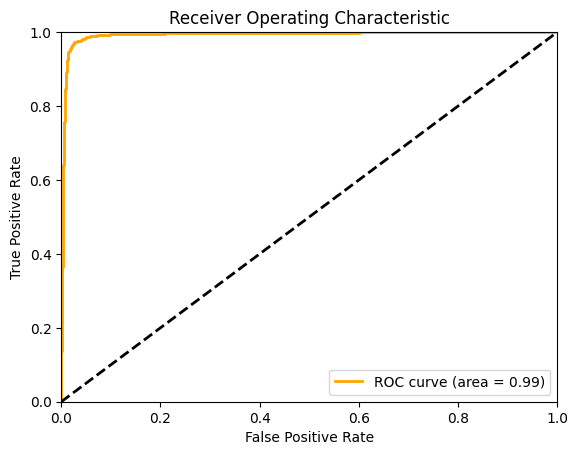

AUC: 0.9922677622574431


In [10]:
# --- determine ROC and AUC
y_pred_prob = log_reg.predict_proba (X_test_scaled)[:, 1] 

def show_roc (y_pred, y_test):
    fpr, tpr, thresholds = roc_curve (y_test, y_pred_prob) 
    roc_auc = roc_auc_score (y_test, y_pred_prob)

    # --- plot ROC 
    plt.figure()
    plt.plot (fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot ([0, 1], [0, 1], color='black', lw=2, linestyle='--') 
    plt.xlim ([0.0, 1.0]) 
    plt.ylim ([0.0, 1.0]) 
    plt.xlabel ('False Positive Rate') 
    plt.ylabel ('True Positive Rate') 
    plt.title ('Receiver Operating Characteristic') 
    plt.legend (loc="lower right") 
    plt.show () 
    print ("AUC:", roc_auc)

show_roc (y_pred_prob, y_test)

In [11]:
# --- determine 
y_pred_log_reg = log_reg.predict (X_test_scaled)
show_confusion_matrix_extended (y_test, y_pred_log_reg)

  Confusion Matrix       |     predicted label     |
                         | Neg        | Pos        |
-------------------------+------------+------------+
              Neg        | TN=   2170 | FP=     90 |
  true label  -----------+------------+------------+
              Pos        | FN=     84 | TP=   3595 |
-------------------------+------------+------------+

    F1-score    = 0.9764
    accuracy    = 0.9707
    precision   = 0.9756    purity
    recall      = 0.9772    sensitivity / efficiency
    FP-rate     = 0.0398    alpha-error
    TP-rate     = 0.9772    1 - beta-error


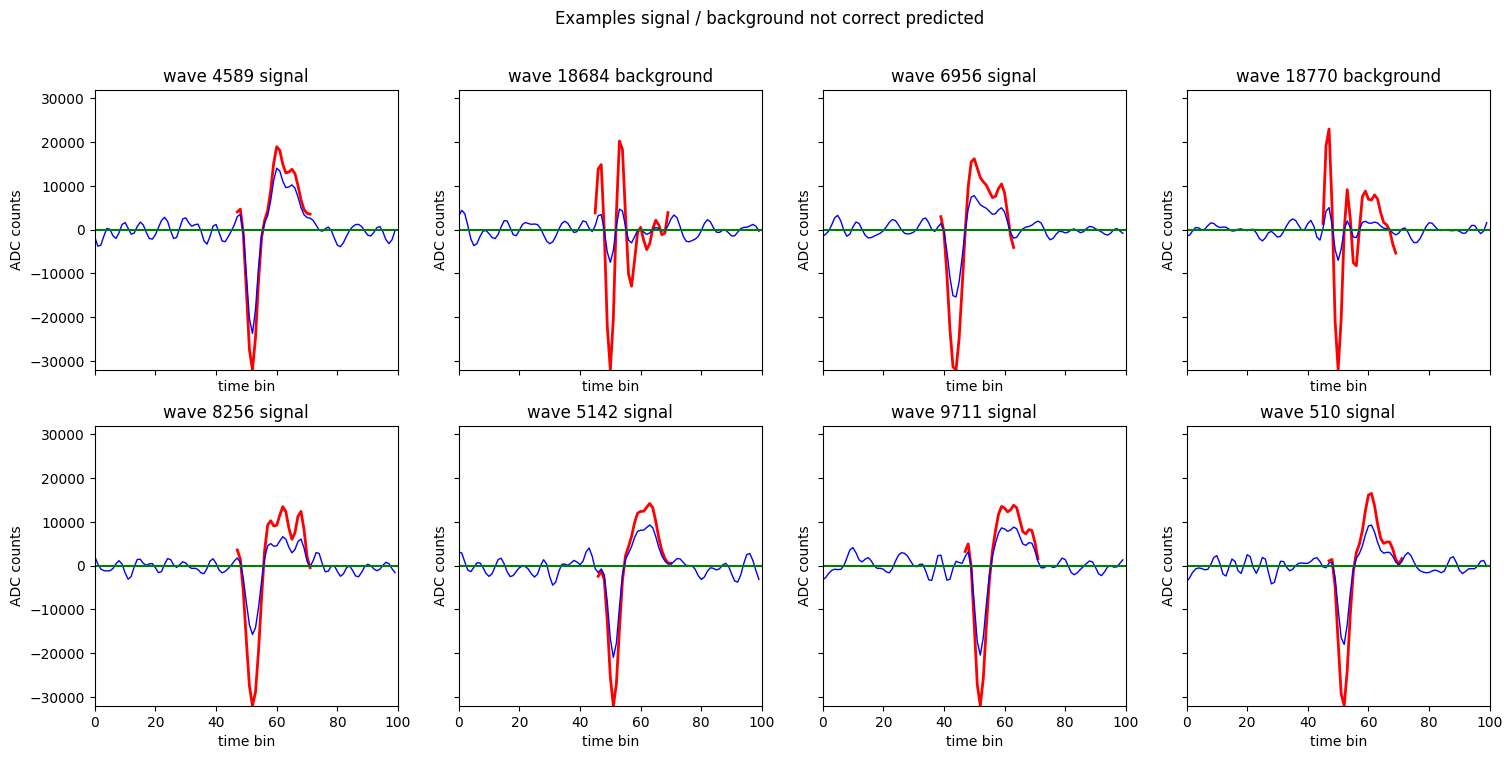

In [12]:
def show_wrong_predicted (y_pred, y_true, X_test_plus, data_complete):
    diff_indices = np.where (np.not_equal (y_pred, y_true))[0]
    wrong_prediction = (X_test_plus [diff_indices,0]).astype (int)

    title = "Examples signal / background not correct predicted"
    figsize = (18.,8.)
    items = np.random.choice (wrong_prediction, size=8, replace=False)
    show_waves (data_complete, title, n_cols=4, n_rows=2, source="defined", items=items, figsize=figsize, \
            withLabel=True, withIndex=True, withOrg=True, withContour=True, withAxisLabelling=True, withZeroLine=True)
    return wrong_prediction
    
wrong_log_reg = show_wrong_predicted (y_pred_log_reg, y_test, X_train_plus, data_complete)

## 4 ML-Algorithmus: Perceptron

In [13]:
perceptron = Perceptron () 
perceptron.fit (X_train_scaled, y_train) 
y_pred_perc = perceptron.predict (X_test_scaled) 
show_confusion_matrix_extended (y_test, y_pred_perc)

  Confusion Matrix       |     predicted label     |
                         | Neg        | Pos        |
-------------------------+------------+------------+
              Neg        | TN=   2150 | FP=    110 |
  true label  -----------+------------+------------+
              Pos        | FN=     74 | TP=   3605 |
-------------------------+------------+------------+

    F1-score    = 0.9751
    accuracy    = 0.9690
    precision   = 0.9704    purity
    recall      = 0.9799    sensitivity / efficiency
    FP-rate     = 0.0487    alpha-error
    TP-rate     = 0.9799    1 - beta-error


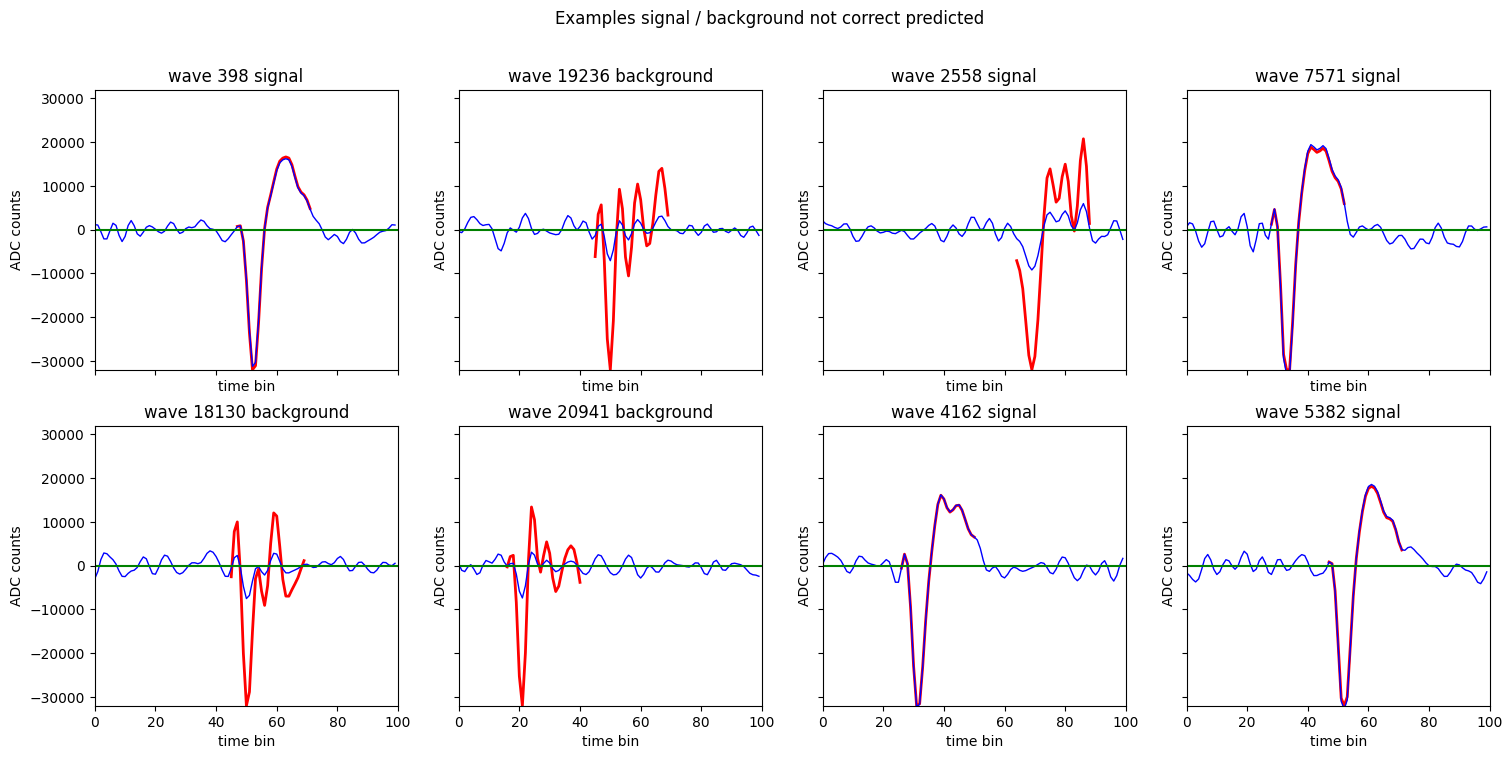

In [14]:
wrong_perc = show_wrong_predicted (y_pred_perc, y_test, X_train_plus, data_complete)

In [15]:
perceptron2 = Perceptron ()
perceptron2.fit (X_train, y_train) 
y_pred_perc2 = perceptron2.predict (X_test) 
show_confusion_matrix_extended (y_test, y_pred_perc2)

  Confusion Matrix       |     predicted label     |
                         | Neg        | Pos        |
-------------------------+------------+------------+
              Neg        | TN=   2093 | FP=    167 |
  true label  -----------+------------+------------+
              Pos        | FN=     50 | TP=   3629 |
-------------------------+------------+------------+

    F1-score    = 0.9710
    accuracy    = 0.9635
    precision   = 0.9560    purity
    recall      = 0.9864    sensitivity / efficiency
    FP-rate     = 0.0739    alpha-error
    TP-rate     = 0.9864    1 - beta-error


## 5 ML-Algorithmus: Neuronales Netz
Es wird nun ein einfaches Neuronales Netz definiert. 
Dazu wird der `MLPClassifier`von `scikit-learn` verwendet.
Als Einstellungen werden (außer bei der Anzahl der Neuron in den versteckten Layern), die Standardeinstellungen verwendet, beispielsweise:
- Aktivierungsfunktion: `relu`
- Lösungsverfahren: `adam`
Neben dem Eingabe-Layer mit 25 Neuronen und dem Ausgabe-Layer mit 2 Neuronen
gibt es versteckte Layer. Für die Größe des Layers werden verschiedene Werte getestet.

Die Daten wurden schon bei der Aufbereitung der Daten skaliert, so dass der maximale (negative) Impuls den Wert -1 hat.

## Erstes Layerdesign

In [16]:
def neunet (X_train, X_test, y_train, y_test, layer_size, max_iter, prot_Short = True, with_train=True):

    # --- define the ML-algorithm
    mlp = MLPClassifier (hidden_layer_sizes=layer_size, max_iter=max_iter, random_state=RANDOM_STATE)

    # --- train the ML-algorithm
    y_train_reshape = y_train.reshape (y_train.size, )
    mlp.fit (X_train, y_train_reshape)

    # --- apply the ML-algorithm to the test data
    y_pred = mlp.predict (X_test)
    y_pred_train = mlp.predict (X_train)

    # --- display results
    layer_size_text = f"{layer_size}"
    if (prot_Short == True):  # --- show figures in one line 
        print (f"{layer_size_text:12s}  test  ", end="")
        show_confusion_matrix_line (y_test, y_pred)
        if with_train:
            print (f"{layer_size_text:12s}  train ", end="")
            show_confusion_matrix_line (y_train, y_pred_train)
    else: 
        print ("Layer-Size : ", layer_size)
        print ("Results test-data")
        show_confusion_matrix_extended (y_test, y_pred, labels = ["background", "signal"])
        print ()
        if with_train:
            print ("Results train-data")
            show_confusion_matrix_extended (y_train, y_pred_train, labels = ["background", "signal"])
            print ()

    return y_pred

In [17]:
layer_size = (15,)
max_iter = 10000
neunet (X_train_scaled, X_test_scaled, y_train, y_test, layer_size, max_iter, prot_Short=False, with_train=False)

print ("key figures              TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1")
y_pred_nn_15 = neunet (X_train_scaled, X_test_scaled, y_train, y_test, layer_size, max_iter, prot_Short=True, with_train=True)

Layer-Size :  (15,)
Results test-data
  Confusion Matrix       |     predicted label     |
                         | background | signal     |
-------------------------+------------+------------+
              background | TN=   2202 | FP=     58 |
  true label  -----------+------------+------------+
              signal     | FN=     72 | TP=   3607 |
-------------------------+------------+------------+

    F1-score    = 0.9823
    accuracy    = 0.9781
    precision   = 0.9842    purity
    recall      = 0.9804    sensitivity / efficiency
    FP-rate     = 0.0257    alpha-error
    TP-rate     = 0.9804    1 - beta-error

key figures              TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1
(15,)         test     3607      72      58    2202  0.9781  0.9842  0.9804  0.0257  0.9804  0.9823
(15,)         train   10810     177     158    6670  0.9812  0.9856  0.9839  0.0231  0.9839  0.9847


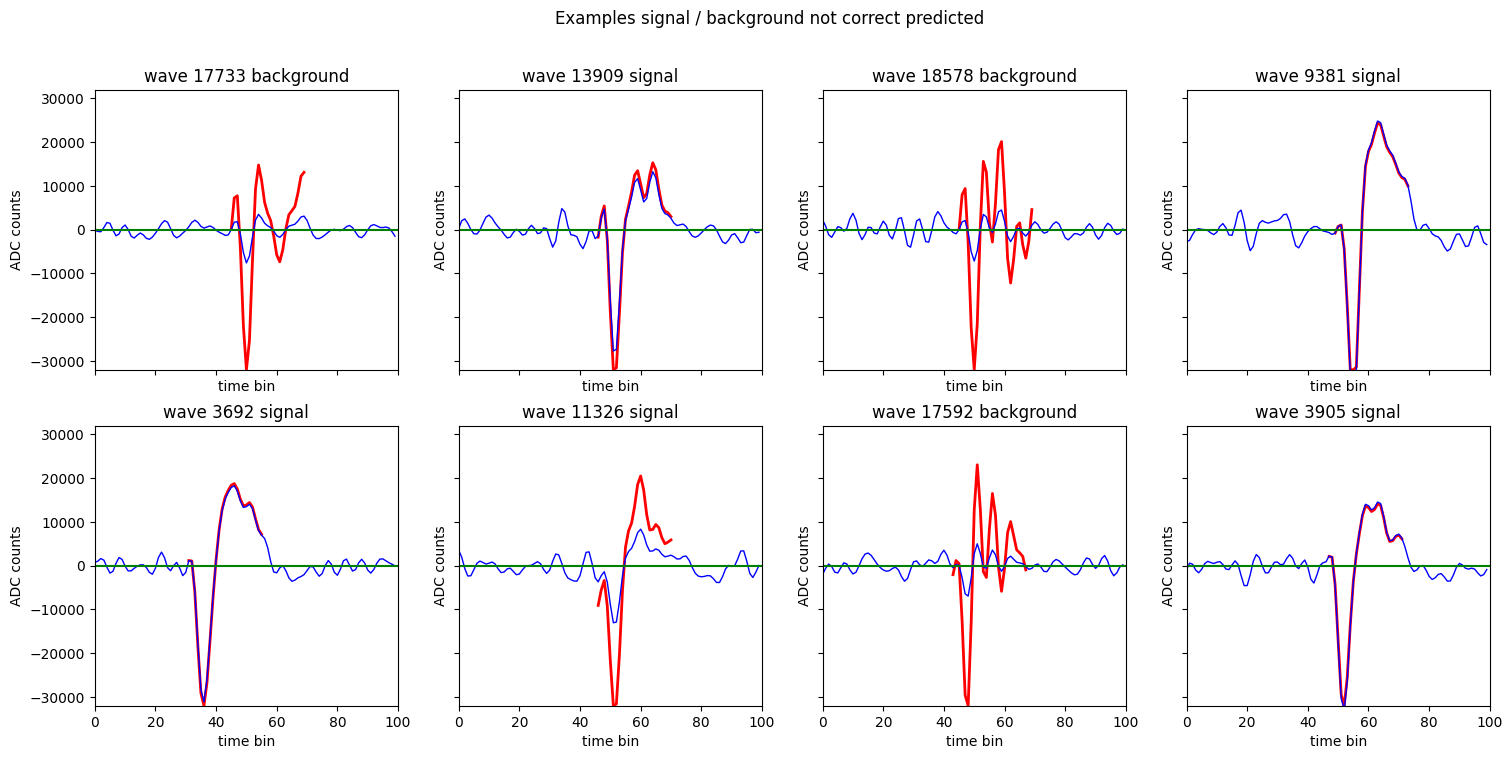

In [18]:
wrong_nn_15 = show_wrong_predicted (y_pred_nn_15, y_test, X_train_plus, data_complete)

### Lernkurve bestimmen

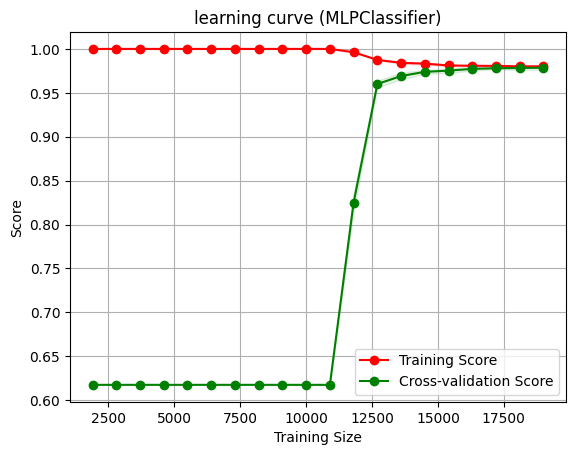

In [19]:
# Lernkurve berechnen 
#X_train_lc = scaler.transform (data_features [:,1:])
X_train_lc = data_features [:,1:] / 32000.0
y_train_lc = data_label
layer_size = (15,)
max_iter = 10000
mlp = MLPClassifier (hidden_layer_sizes=layer_size, max_iter=max_iter, random_state=RANDOM_STATE)
train_sizes, train_scores, test_scores = learning_curve (mlp, X_train_lc, y_train_lc, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 20)) 
# --- calculate mean and std of traing and test accuracy 
train_scores_mean = np.mean (train_scores, axis=1) 
train_scores_std = np.std (train_scores, axis=1) 
test_scores_mean = np.mean (test_scores, axis=1) 
test_scores_std = np.std (test_scores, axis=1)

# --- plot learning curve
plt.figure() 
plt.title ("learning curve (MLPClassifier)") 
plt.xlabel ("Training Size") 
plt.ylabel ("Score") 
plt.grid() 

plt.fill_between (train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r") 
plt.fill_between (train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g") 

plt.plot (train_sizes, train_scores_mean, 'o-', color="r", label="Training Score") 
plt.plot (train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score") 
plt.legend (loc="best") 
plt.show()

### Anwendung CV für verschiedene Layerdesigns
Im Nachfolgenden werden verschiedene Layer-Strukturen durchgearbeitet. Dabei wird mittels Cross Validation, die gesammten Lerndaten bearbeitet.
Es wird ein Neronales Netz angewendet.

In [20]:
k_splits = 10
cv = KFold (shuffle = True, n_splits = k_splits, random_state=RANDOM_STATE)

def print_distribution (train, test, label):
    unique, counts = np.unique (label [train], return_counts=True)
    #print (unique)
    n_train_signal = counts [1]
    n_train_background = counts [0]
    unique, counts = np.unique (label [test], return_counts=True)
    n_test_signal = counts [1]
    n_test_background = counts [0]
    print (f" train [{n_train_signal:6.0f} - {n_train_background:6.0f}]", end = "")
    print (f"  test [{n_test_signal:6.0f} - {n_test_background:6.0f}]")

for train, test in cv.split (X_train_lc, y_train_lc):
    print_distribution (train, test, y_train_lc)


 train [ 13208 -   8170]  test [  1458 -    918]
 train [ 13186 -   8192]  test [  1480 -    896]
 train [ 13214 -   8164]  test [  1452 -    924]
 train [ 13189 -   8189]  test [  1477 -    899]
 train [ 13187 -   8192]  test [  1479 -    896]
 train [ 13189 -   8190]  test [  1477 -    898]
 train [ 13198 -   8181]  test [  1468 -    907]
 train [ 13190 -   8189]  test [  1476 -    899]
 train [ 13235 -   8144]  test [  1431 -    944]
 train [ 13198 -   8181]  test [  1468 -    907]


In [21]:
def print_scores (scores, scoring):
    print ("scoring: ", scoring)
    print ("test set  : ", end = "")
    for score in scores ['test_score']:
        print (f"  {score:6.4f}", end = "")
    print ()
    print ("train set : ", end = "")
    for score in scores ['train_score']:
        print (f"  {score:6.4f}", end = "")
    print ()

    print (f"{scoring:s} training set: {scores ['train_score'].mean():6.4f} +/- {scores ['train_score'].std():6.4f}")
    print (f"{scoring:s} test     set: {scores ['test_score'].mean():6.4f} +/- {scores ['test_score'].std():6.4f}")


#layer_sizes = [(25,), (20,), (15,), (10,), (5,), (4,), (3,), (2,), (15,5), (15,10), (15,15), (10, 5), (15,10,5)]
layer_sizes = [(15,), (5,), (15,10)]
max_iter = 10000
#prot_Short
#if (prot_Short):
#    print ("key figures              TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1")
scoring='accuracy'
for layer_size in layer_sizes:
    print ("layer size: ", layer_size)
    start_time = time.time ()
    mlp_model = MLPClassifier (hidden_layer_sizes=layer_size, max_iter=max_iter, random_state=RANDOM_STATE)
    scores = cross_validate (mlp_model, X_train_lc, y_train_lc, cv=cv, scoring=scoring, return_train_score = True)
    end_time = time.time ()
    elapsed_time = end_time - start_time
    print_scores (scores, scoring)
    print (f"time used : {elapsed_time:6.1f} s")
    print ()


layer size:  (15,)
scoring:  accuracy
test set  :   0.9785  0.9790  0.9764  0.9832  0.9789  0.9794  0.9773  0.9802  0.9773  0.9806
train set :   0.9799  0.9807  0.9806  0.9789  0.9812  0.9790  0.9817  0.9795  0.9804  0.9812
accuracy training set: 0.9803 +/- 0.0009
accuracy test     set: 0.9791 +/- 0.0019
time used :   52.2 s

layer size:  (5,)
scoring:  accuracy
test set  :   0.9764  0.9790  0.9747  0.9798  0.9743  0.9802  0.9722  0.9789  0.9789  0.9756
train set :   0.9778  0.9778  0.9788  0.9773  0.9786  0.9786  0.9789  0.9780  0.9784  0.9789
accuracy training set: 0.9783 +/- 0.0005
accuracy test     set: 0.9770 +/- 0.0026
time used :   45.0 s

layer size:  (15, 10)
scoring:  accuracy
test set  :   0.9798  0.9811  0.9785  0.9819  0.9773  0.9836  0.9747  0.9806  0.9756  0.9781
train set :   0.9830  0.9819  0.9819  0.9817  0.9833  0.9816  0.9830  0.9821  0.9827  0.9815
accuracy training set: 0.9823 +/- 0.0006
accuracy test     set: 0.9791 +/- 0.0027
time used :   81.8 s



In [22]:
layer_sizes = [(5,), (10,), (15,), (20,), (25,), (30,), (40,), (50,), (4,), (3,), (2,), (5,5), (10,5), (15,5), (15,10), (15,15), (15,10,5)]
#layer_sizes = [(5,)]
max_iter = 10000
#print ("key figures              rec       time ")
prot_Short = True
if (prot_Short):
    print ("key figures      TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1")

for layer_size in layer_sizes:
    layer_size_text = f"{layer_size}"
    print (f"{layer_size_text:12s}", end = "")
    start_time = time.time ()
    mlp_model = MLPClassifier (hidden_layer_sizes=layer_size, max_iter=max_iter, random_state=RANDOM_STATE)
    mlp_model.fit (X_train_scaled, y_train)
    end_time = time.time ()
    elapsed_time = end_time - start_time
    y_pred = mlp_model.predict (X_test_scaled)
    show_confusion_matrix_line (y_test, y_pred, with_time=True, elapsed_time=elapsed_time, asLaTeX=False)

key figures      TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1
(5,)           3607      72      67    2193  0.9766  0.9818  0.9804  0.0296  0.9804  0.9811     4.1 s
(10,)          3607      72      82    2178  0.9741  0.9778  0.9804  0.0363  0.9804  0.9791     3.9 s
(15,)          3607      72      58    2202  0.9781  0.9842  0.9804  0.0257  0.9804  0.9823     5.2 s
(20,)          3613      66      57    2203  0.9793  0.9845  0.9821  0.0252  0.9821  0.9833     6.3 s
(25,)          3622      57      57    2203  0.9808  0.9845  0.9845  0.0252  0.9845  0.9845     5.8 s
(30,)          3618      61      55    2205  0.9805  0.9850  0.9834  0.0243  0.9834  0.9842     8.8 s
(40,)          3622      57      57    2203  0.9808  0.9845  0.9845  0.0252  0.9845  0.9845     7.6 s
(50,)          3620      59      58    2202  0.9803  0.9842  0.9840  0.0257  0.9840  0.9841    10.7 s
(4,)           3597      82      87    2173  0.9715  0.9764  0.9777  0.0385  0.9777  0.9770     

### Wellen die bei allen drei Verfahren falsch zugeordnet sind

number of wrong predictions with all 3 methods:  91
[  309   398   510   601   874   944  1579  1594  2058  3099  3195  3307
  3619  3692  3905  4162  4169  4589  4866  5142  5647  5770  5861  6492
  6840  6956  7161  7361  7488  7541  7676  7802  8723  9197  9381  9711
 10033 10722 11000 11305 11326 11365 11379 11584 11611 11923 12044 12077
 12163 13722 13735 13909 14070 14467 14662 14790 14880 15759 16155 17126
 17264 17410 17592 17710 17733 17987 18130 18169 18274 18319 18364 18578
 18605 18763 18830 19195 19264 19434 19926 20106 20269 20391 20481 20506
 20850 21569 21932 22028 22131 22176 22942]


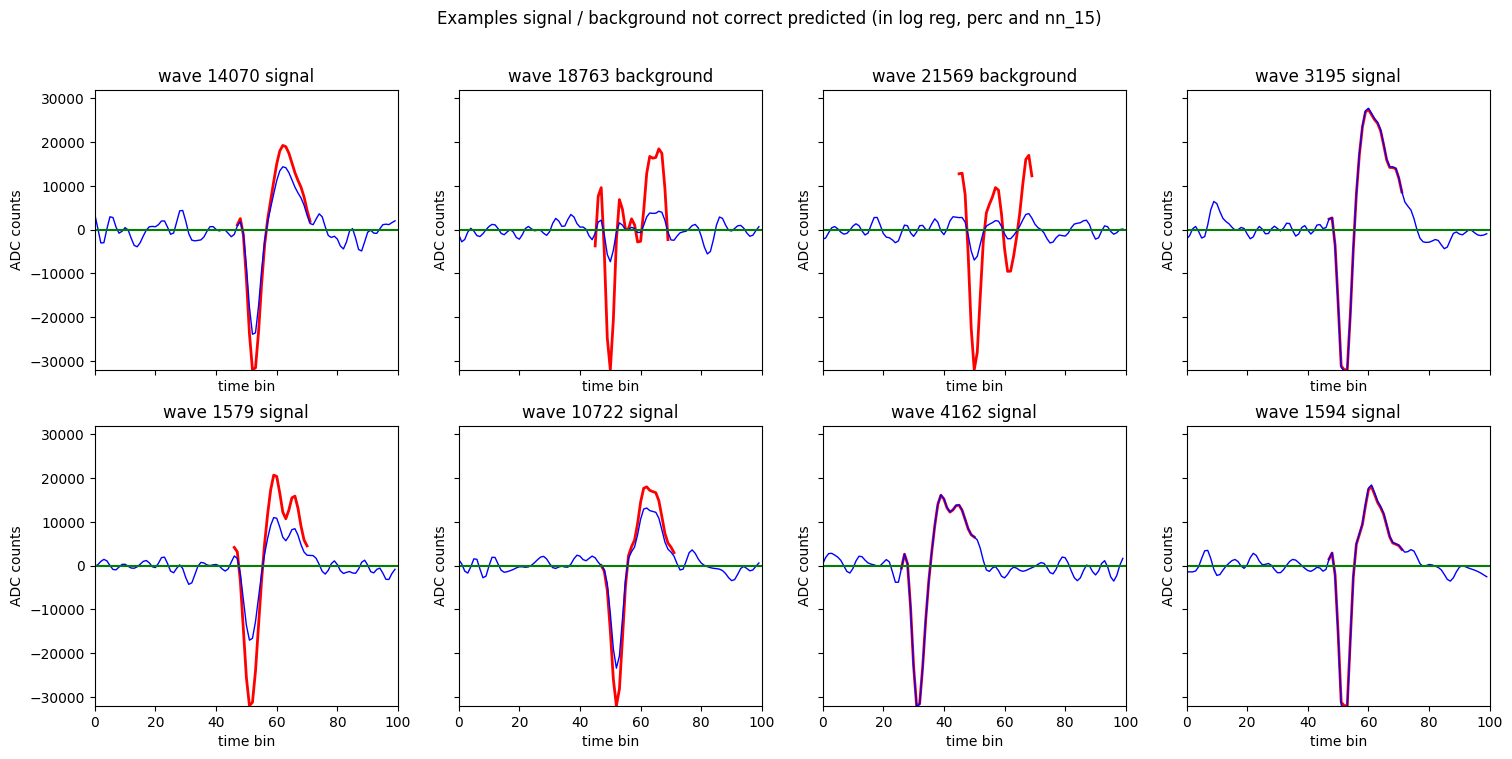

In [23]:
wrong = np.intersect1d (np.intersect1d (wrong_log_reg, wrong_perc), wrong_nn_15)
print ("number of wrong predictions with all 3 methods: ", len (wrong))
print (wrong)

title = "Examples signal / background not correct predicted (in log reg, perc and nn_15)"
figsize = (18.,8.)
items = np.random.choice (wrong, size=8, replace=False)
show_waves (data_complete, title, n_cols=4, n_rows=2, source="defined", items=items, figsize=figsize, \
            withLabel=True, withIndex=True, withOrg=True, withContour=True, withAxisLabelling=True, withZeroLine=True)

End